# DEAP - CIRUGÍAS

## Librerías

In [41]:
import operator
import random
import numpy as np
import pandas as pd
import operator
import pygraphviz as pgv
import networkx as nx
import matplotlib.pyplot as plt
from deap import algorithms, base, creator, tools, gp
import time
import json
import sys

print("Librerías cargadas.");

import os
import sys
notebook_dir = os.getcwd()
os.chdir = notebook_dir
print("Working directory set:", notebook_dir);

sys.path.append("./algorithm")

Librerías cargadas.
Working directory set: c:\Users\HP\Python\Jupyter Notebook\Universidad\Tesis


## Old

In [2]:
pset = gp.PrimitiveSet("MAIN", 0);

#TERMINALES
def asignar_primero(paciente, cirujano):
    if paciente in pacientes and cirujano in cirujanos and pacientes[paciente] in cirujanos[cirujano]:
        asignaciones[paciente] = cirujano

def quitar(paciente):
    if paciente in asignaciones:
        del asignaciones[paciente]

for paciente in pacientes:
    pset.addTerminal(paciente)

for cirujano in cirujanos:
    pset.addTerminal(cirujano)

pset.addPrimitive(asignar, 2)
pset.addPrimitive(quitar, 1)

pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(operator.not_, 1)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalSchedule(individual):
    global schedule, O, D, T, pacientes
    schedule.clear()
    func = toolbox.compile(expr=individual)
    func();
    score = 0
    pacientes_asign = [];
    for col in range(len(schedule[0])):
        p = schedule[0][col]
        if p != 0 and p not in pacientes_asign:
            pacientes_asign.append(p)
            score += pacientes[p][0]
    score *= 1000;
    penalizacion = 0;
    for o in O:
        for t in range(1, len(D) * len(T) + 1):
            registro = {};
            for col in range(len(schedule[0])):
                if schedule[0][col] == o:
                    bloque = schedule[3][col];
                    if bloque == t:
                        or_id = schedule[2][col]
                        if or_id in registro:
                            penalizacion += 100;
                        else:
                            registro[or_id] = 1;
    score -= penalizacion;
    return score, 


toolbox.register("evaluate", evalPlanificacion);
toolbox.register("select", tools.selTournament, tournsize=3);
toolbox.register("mate", gp.cxOnePoint);
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset);
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17));
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17));

# Función principal para ejecutar el algoritmo genético
def main():
    random.seed(258)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.1, 50, stats=mstats, halloffame=hof, verbose=True)
    best_ind = tools.selBest(pop, 1)[0]
    print("Mejor individuo es:", best_ind)
    print("Con un fitness de:", best_ind.fitness.values)

    return pop, log, hof

if __name__ == "__main__":
    main()

NameError: name 'pacientes' is not defined

In [ ]:
import numpy as np
import pandas as pd

pacientes_asign = set();
registros = set();

def evalAllORs(or_schedules):
    puntaje = 0
    for or_id, schedule in or_schedules.items():
        points = evalSchedule(schedule, or_id);
        puntaje += points;
        print(f"Score para OR {or_id}: {points}.\n");
    return puntaje

def evalSchedule(schedule, or_id):
    if schedule.size == 0:
        print(f"No hay asignaciones para este OR {or_id}.")
        return 0;
    bloques_por_paciente = {};
    penalizaciones = 0;
    registros = set();
    score = 0;
    for i in range(schedule.shape[1]):  #Recorrer todas las asignaciones en este OR
        paciente_id = schedule[0, i];
        cirujano_principal_id = schedule[1, i];
        cirujano_secundario_id = schedule[2, i];
        bloque_horario = schedule[3, i];
        prioridad_paciente = pacientes[paciente_id][1];
        if paciente_id not in bloques_por_paciente:
            bloques_por_paciente[paciente_id] = [];
            score += 1000 * prioridad_paciente;
        bloques_por_paciente[paciente_id].append(bloque_horario);
        especialidad_requerida = pacientes[paciente_id][0];
        if cirujanos[cirujano_principal_id] != especialidad_requerida:
            penalizaciones += 10;  #Penalización si la especialidad no coincide
            print(f"Penalización: Especialidad del cirujano no coincide para paciente {paciente_id} en OR {or_id}.");
        if cirujano_principal_id == cirujano_secundario_id:
            penalizaciones += 10;
            print(f"Penalización: Cirujano principal y secundario son la misma persona para paciente {paciente_id} en OR {or_id}.");
        if (cirujano_principal_id, bloque_horario) in registros:
            penalizaciones += 50;  #Penalización por asignar a un mismo bloque horario
            print(f"Penalización: Cirujano {cirujano_principal_id} reasignado en el mismo bloque {bloque_horario} en OR {or_id}.");
        registros.add((cirujano_principal_id, bloque_horario)); #Aregar
    for paciente_id, bloques in bloques_por_paciente.items():
        bloques.sort();
        duracion = pacientes[paciente_id][2];
        if len(bloques) != duracion:
            penalizaciones += 50 * len(bloques); #Penalizar por cada bloque asignaod mal
            print(f"Penalización: Duración incorrecta para paciente {paciente_id} en OR {or_id}. Esperado: {duracion}, Obtenido: {len(bloques)}.");
        if not all(bloques[i] + 1 == bloques[i + 1] for i in range(len(bloques) - 1)):
            penalizaciones += 100 * len(bloques); #Penalización por cada bloque no consecutivo
            print(f"Penalización: Bloques no consecutivos para paciente {paciente_id} en OR {or_id}.");

    score -= 10 * penalizaciones;  #Restar las penalizaciones del score total
    print(f"Score final para OR {or_id}: {score}");
    return score

### Validación

In [ ]:
or_schedules = {
    1: np.array([
        [1, 1],
        [1, 1],
        [2, 2],
        [1, 1]]),
    2: np.array([
        [3, 7, 6],
        [2, 2, 2],
        [1, 2, 1],
        [1, 2, 10]]),
    3: np.array([
        [4, 5],
        [3, 3],
        [4, 4],
        [2, 3]]),
    4: np.array([
        [0],
        [0],
        [0],
        [0]])};

pacientes_asign = set();
registros = set();
total_score = evalAllORs(or_schedules)
print("Score total:", total_score)

In [ ]:
def generar_solucion_factible(D, T):
    global pacientes, cirujanos, ors
    def encontrar_paciente_cirujano(asignados, especialidad):
        for paciente_id, (pac_esp, _, duracion) in pacientes.items():
            if paciente_id not in asignados and pac_esp == especialidad:
                for cirujano_id, cir_esp in cirujanos.items():
                    if cir_esp == especialidad:
                        cirujano_secundario_id = next((id for id in cirujanos if id != cirujano_id), None);
                        if cirujano_secundario_id:
                            return paciente_id, cirujano_id, cirujano_secundario_id, duracion
        return None, None, None, None

    def asignar_paciente(schedule, paciente_id, cirujano_principal_id, cirujano_secundario_id, day, block, duracion, T):
        for b in range(duracion):
            actual_block = (day - 1) * T + block + b;
            schedule.append([paciente_id, cirujano_principal_id, cirujano_secundario_id, actual_block]);

    def es_bloque_disponible(schedule, block, day, duracion, T):
        start_block = (day - 1) * T + block;
        end_block = start_block + duracion - 1;
        if end_block > day * T:
            return False
        existing_blocks = set(b for _, _, _, b in schedule);
        return all(b not in existing_blocks for b in range(start_block, end_block + 1))
    or_schedules = {or_id: [] for or_id in ors};
    asignados = set();
    for or_id, config in ors.items():
        for day in range(1, D + 1):
            morning_specialty, afternoon_specialty = config[day-1];
            for specialty, time_frame in [(morning_specialty, range(1, T // 2 + 1)), (afternoon_specialty, range(T // 2 + 1, T + 1))]:
                if specialty:
                    for block in time_frame:
                        if es_bloque_disponible(or_schedules[or_id], block, day, 1, T):
                            paciente_id, cirujano_principal_id, cirujano_secundario_id, duracion = encontrar_paciente_cirujano(asignados, specialty);
                            if paciente_id:
                                asignar_paciente(or_schedules[or_id], paciente_id, cirujano_principal_id, cirujano_secundario_id, day, block, duracion, T);
                                asignados.add(paciente_id);
                                break
    return {or_id: np.array(schedule).T if schedule else np.empty((4, 0)) for or_id, schedule in or_schedules.items()}

solucion_inicial = generar_solucion_factible(len(D), len(T));
print(solucion_inicial);

print(evalAllORs(solucion_inicial));

In [ ]:
def tabular_solucion(solucion, T):
    or_tables = {};
    for or_id, datos in solucion.items():
        if datos.size == 0:
            or_tables[or_id] = pd.DataFrame();
            continue
        df = pd.DataFrame(datos.T, columns=["Paciente", "Cirujano Principal", "Cirujano Secundario", "Bloque Horario"]);
        df["Día"] = (df["Bloque Horario"] - 1) // T + 1;
        df["Bloque en Día"] = (df["Bloque Horario"] - 1) % T + 1;
        df["Especialidad"] = df["Paciente"].apply(lambda x: pacientes[x][0]);
        #max_dias = df["Día"].max();
        max_dias = D[-1];
        tabla = pd.DataFrame(index=range(1, T+1), columns=range(1, max_dias+1));
        for _, row in df.iterrows():
            day = row["Día"];
            block = row["Bloque en Día"];
            tabla.at[block, day] = (row["Paciente"], row["Cirujano Principal"], row["Cirujano Secundario"], row["Especialidad"]);
        or_tables[or_id] = tabla;
    return or_tables

#print(tabular_solucion(solucion_inicial, len(T)));
tabular_solucion(solucion_inicial, len(T))[2].head(len(T))

## Cargar datos

In [29]:
testing = False;
version = "A";
solucion_inicial = None;
print(f"Configurado con testing = {testing}. Versión: {version}.");

Configurado con testing = False. Versión: A.


In [33]:
import warnings
import json
import pandas as pd
import random
import numpy as np
import time

warnings.filterwarnings("ignore")

if testing == False:
    with open("./Input/instancias.json") as file:
        data = json.load(file);
else:
    with open("./Input/inst_test.json") as file:
        data = json.load(file);
    
config = data["configurations"];
dfSolucion = pd.DataFrame();
dfSolucion.to_excel("./Output/output.xlsx", index=False);
                    
dfSurgeon = pd.read_excel("./Input/MAIN_SURGEONS.xlsx", sheet_name='surgeon', converters={'n°':int}, index_col=[0]);
dfSecond = pd.read_excel("./Input/SECOND_SURGEONS.xlsx", sheet_name='second', converters={'n°':int}, index_col=[0]);
dfRoom = pd.read_excel("./Input/ROOMS.xlsx", sheet_name='room', converters={'n°':int}, index_col=[0]);
dfType = pd.read_excel("./Input/PROCESS_TYPE.xls", sheet_name='Process Type', converters={'n°':int}, index_col=[0]);
                    
extras = [];
dfdisORA = pd.read_excel("./Input/DIST_OR_EXT.xlsx", sheet_name='A', converters={'n°':int}, index_col=[0]);
dfdisORA = dfdisORA.astype(str).values.tolist();
extraA = [];
for i in range(len(dfdisORA)):
    extraA.append(dfdisORA[i].copy());
for i in range(len(dfdisORA[0])):
    aux = dfdisORA[0][i].split(";");
    dfdisORA[0][i] = aux[0];
    extraA[0][i] = aux[1:];
    aux = dfdisORA[1][i];
    aux = aux.split(";");
    dfdisORA[1][i] = aux[0];
    extraA[1][i] = aux[1:];
    num_ext = len(extraA[1][i]);
extras.append(extraA);

dfdisORB = pd.read_excel("./Input/DIST_OR_EXT.xlsx", sheet_name='B', converters={'n°':int}, index_col=[0]);
dfdisORB = dfdisORB.astype(str).values.tolist();
extraB = [];
for i in range(len(dfdisORB)):
    aux = dfdisORB[i].copy();
    extraB.append(aux);
for i in range(len(dfdisORB[0])):
    aux = dfdisORB[0][i];
    aux = aux.split(";");
    dfdisORB[0][i] = aux[0];
    extraB[0][i] = aux[1:];
    aux = dfdisORB[1][i];
    aux = aux.split(";");
    dfdisORB[1][i] = aux[0];
    extraB[1][i] = aux[1:];
extras.append(extraB);

dfdisORC = pd.read_excel("./Input/DIST_OR_EXT.xlsx", sheet_name='C', converters={'n°':int}, index_col=[0]);
dfdisORC = dfdisORC.astype(str).values.tolist();
extraC = [];
for i in range(len(dfdisORC)):
    aux = dfdisORC[i].copy();
    extraC.append(aux);
for i in range(len(dfdisORC[0])):
    aux = dfdisORC[0][i];
    aux = aux.split(";");
    dfdisORC[0][i] = aux[0];
    extraC[0][i] = aux[1:];
    aux = dfdisORC[1][i];
    aux = aux.split(";");
    dfdisORC[1][i] = aux[0];
    extraC[1][i] = aux[1:];
extras.append(extraC);

dfdisORD = pd.read_excel("./Input/DIST_OR_EXT.xlsx", sheet_name='D', converters={'n°':int}, index_col=[0]);
dfdisORD = dfdisORD.astype(str).values.tolist();
extraD = [];
for i in range(len(dfdisORD)):
    aux = dfdisORD[i].copy();
    extraD.append(aux);
for i in range(len(dfdisORD[0])):
    aux = dfdisORD[0][i];
    aux = aux.split(";");
    dfdisORD[0][i] = aux[0];
    extraD[0][i] = aux[1:];
    aux = dfdisORD[1][i];
    aux = aux.split(";");
    dfdisORD[1][i] = aux[0];
    extraD[1][i] = aux[1:];
extras.append(extraD);

dfdisAffi = pd.read_excel("./Input/AFFINITY_EXT.xlsx", sheet_name='Hoja1', converters={'n°':int}, index_col=[0]);
dfdisAffiDiario = pd.read_excel("./Input/AFFINITY_DIARIO.xlsx", sheet_name='Dias', converters={'n°':int}, index_col=[0]);
dfdisAffiBloque = pd.read_excel("./Input/AFFINITY_DIARIO.xlsx", sheet_name='Bloques', converters={'n°':int}, index_col=[0]);
dfdisRank = pd.read_excel("./Input/RANKING.xlsx", sheet_name = 'Hoja1', converters={'n°':int}, index_col=[0]);

extra = [];
dfExtra = [];
for i in range(num_ext):
    aux = pd.read_excel("./Input/AFFINITY_EXT.xlsx", sheet_name='Extra'+str(i+1), converters = {'n°':int}, index_col=[0]);
    extra.append(len(aux));
    dfExtra.append(aux);

# Rankings para extras
dfRankExtra = [];
for i in range(num_ext):
    aux = pd.read_excel("./Input/RANKING.xlsx", sheet_name='Extra'+str(i+1), converters = {'n°':int}, index_col=[0]);
    extra.append(len(aux));
    dfRankExtra.append(aux);

#-------------------------------------------------------------------------------------------------------------------------------#     
########################################################### MAIN LOOP ###########################################################
#-------------------------------------------------------------------------------------------------------------------------------#  

for INS in config:
    dfSolucion = pd.read_excel("./Output/output.xlsx");
    #version = INS["version"];
    version = version;
    typePatients = INS["patients"];
    nDays = int(INS["days"]);
    min_affinity = int(INS["min_affinity"]);
    nSurgeons = int(INS["surgeons"]);
    nFichas = int(INS["fichas"]);
    time_limit = int(INS["time_limit"]);

    patient_code = "0" if typePatients == "low" else ("1" if typePatients == "high" else "2");
    print(f"Versión: {version};\nPacientes: {typePatients}; Días: {nDays};\nAfinidad: {min_affinity}; Cirujanos: {nSurgeons};\nFichas: {nFichas}.");
    
    #list_sol = [instancia[INS][0]+"_"+instancia[INS][1],"","","","","","","","","","","","","",""];
    dict_sol = {"Instancia": [f"v{version}p{patient_code}s{nSurgeons}d{nDays}"]};
    
    nPatients = 160;
    if typePatients == "low":
        dfPatient = pd.read_csv("./Input/LowPriority.csv");
    elif typePatients == "high":
        dfPatient = pd.read_csv("./Input/HighPriority.csv");
    else:
        dfPatient = pd.read_csv("./Input/AllPriority.csv");

    # Indices
    random.seed(0);
    patient = [p for p in range(nPatients)];
    surgeon = [s for s in range(nSurgeons)];
    second = [a for a in range(nSurgeons)]
    room = [o for o in range(len(dfRoom))]
    day = [d for d in range(nDays)];
    nSlot = 16;  # Bloques de 30 minutos
    nRooms = len(room);
    slot = [t for t in range(nSlot)]
    T = nSlot//2; # División entre mañana y tarde
    
    process=[t for t in range(len(dfType))] # ?
    level_affinity = min_affinity;

    # Arcos
    arcox = [(p,o,s,a,t,d) for p in patient for o in room for s in surgeon for a in second for t in slot for d in day];
    arcoy = [(p,o,d) for p in patient for o in room for d in day];
    arcoz = [(p,s,a) for p in patient for s in surgeon for a in second];
    arcot = [p for p in patient];
    arcof = [(s,d) for s in surgeon for d in [a for a in range(-1, nDays)]];

    #Max surgeries and budget per surgeon
    M = np.zeros(nSurgeons, dtype=int);
    Pr = np.zeros(nSurgeons, dtype=int);
    for s in surgeon:
        M[s] = int(dfSurgeon.iloc[s][8]); # Máximo de cirugías
        Pr[s] = int(dfSurgeon.iloc[s][11]); # Presupuesto de fichas

    E = np.ones((nSlot, nDays)) * 1000; # ? 
    A = np.ones((nSlot, nDays)) * 1000; # ?
    B = np.ones(nPatients) * 1; # ?
    Y = np.ones(nPatients) * 1; # ?

    # Prioridades
    I = np.ones((nPatients, nDays), dtype=int);
    for p in patient:
        for d in day:
            try:
                I[(p,d)] = 1 + dfPatient.iloc[p]["espera"] * dfPatient.iloc[p]["edad"] * 0.0001/(d+1);
            except ValueError:
                print("Value Error en cálculo de prioridades.");

    # Matriz de coincidencia cirujanos
    COIN = np.zeros((nSurgeons, nSurgeons), dtype=int);
    for s in surgeon:
        for a in second:
            if dfSurgeon.iloc[s][0] == dfSecond.iloc[a][0]:
                COIN[(s,a)] = 1;
            else:
                COIN[(s,a)] = 0;
                

    Ex = [np.ones((nSurgeons, extra[i]), dtype=float) for i in range(num_ext)];
    for i in range(num_ext):
        for s in surgeon:
            for e in range(extra[i]):
                Ex[i][(s,e)] = dfExtra[i].iloc[e][s+1];

    # Disponibilidad de cirujanos
    # SD = np.zeros((nSurgeons, nSurgeons, nSlot, nDays%5), dtype=int);
    # for s in surgeon:
    #     for a in second:
    #         for d in day:
    #             if dfSurgeon.iloc[s][2+d%5] == 1:
    #                 if dfSecond.iloc[a][2+d%5] == 1:
    #                     if dfSurgeon.iloc[s][1] == 1:
    #                         if dfSecond.iloc[a][1] == 1:
    #                             for t in range(nSlot//T):
    #                                 SD[(s,a,t%2,d%5)] = 1;
    #                     if dfSurgeon.iloc[s][2] == 1:
    #                         if dfSecond.iloc[a][2] == 1:
    #                             for t in range(nSlot//T, nSlot):
    #                                 SD[(s,a,t%2,d%5)] = 1;

    # Disponibilidad de paciente
    DISP = np.ones(nPatients);
    
    def busquedaType(especialidad):
        indice = 0;
        for i in range(len(process)):
            if (especialidad == dfType.iloc[i][0]):
                indice = i;
        return indice
    
    # Compatibilidad paciente-cirujano
    SP = np.zeros((nPatients, nSurgeons), dtype=int);
    contador = 0;
    for p in patient:
        #print(dfPatient.iloc[p][21])
        for s in surgeon:
            if busquedaType(dfPatient.iloc[p]["especialidad"]) == busquedaType(dfSurgeon.iloc[s][9]):
                #print(dfPatient.iloc[p][21])
                SP[p][s] = 1;            

    # Diccionario de paciente
    dic_p = {p: [0, 0, 0, 0, 0] for p in patient};
    for p in patient:
        #dic_p[p][0] = list_patient[p] #paciente y número aleatorio asociado (entre 0 y 1)
        dic_p[p][1] = busquedaType(dfPatient.iloc[p]["especialidad"]) # ID Especialidad
        dic_p[p][2] = dfPatient.iloc[p]["nombre"]; #Nombre del paciente
        dic_p[p][3] = p; # ID
        dic_p[p][4] = dfPatient.iloc[p]["especialidad"]; # Especialidad requerida

    # Compatibilidad quirófano-paciente
    AOR = np.zeros((nPatients, nRooms, nSlot, 5));
    dicOR = {o:[] for o in room};
    j = [];
    z = [];
    ns = 0;
    for o in room:
        if o == 0:
            for d in range(5):
                for e in range(2):
                    #print(e)
                    if e == 0:                    
                        for t in range(len(slot)//2):

                            j = dfdisORA[e][d%5];
                            j = j.split("#")
                            for a in range(len(j)):
                                z=j[a]
                                dicOR[ns]=[o,d%5,t,z]
                                ns+=1
                    if e==1:
                        #print('paso')
                        for t in range(int(len(slot)/2),len(slot)):

                            j=dfdisORA[e][d%5]
                            j=j.split("#")
                            for a in range(len(j)):
                                z=j[a]
                                dicOR[ns]=[o,d%5,t,z]
                                ns+=1
        if o==1:
            for d in range(5):
                for e in range(2):
                    if e==0:                    
                        for t in range(0,int(len(slot)/2)):
                            j=dfdisORB[e][d%5]
                            j=j.split("#")
                            for a in range(len(j)):
                                z=j[a]
                                dicOR[ns]=[o,d,t,z]
                                ns+=1
                    if e==1:
                        for t in range(int(len(slot)/2),len(slot)):
                            j=dfdisORB[e][d%5]
                            j=j.split("#")
                            for a in range(len(j)):
                                z=j[a]
                                dicOR[ns]=[o,d,t,z]
                                ns+=1
        if o==2:
            for d in range(5):
                for e in range(2):
                    if e==0:                    
                        for t in range(0,int(len(slot)/2)):
                            j=dfdisORC[e][d%5]
                            j=j.split("#")
                            for a in range(len(j)):
                                z=j[a]
                                dicOR[ns]=[o,d,t,z]
                                ns+=1
                    if e==1:
                        for t in range(int(len(slot)/2),len(slot)):
                            j=dfdisORC[e][d%5]
                            j=j.split("#")
                            for a in range(len(j)):
                                z=j[a]
                                dicOR[ns]=[o,d,t,z]
                                ns+=1
        if o==3:
            for d in range(5):
                for e in range(2):
                    if e==0:                    
                        for t in range(0,int(len(slot)/2)):
                            j=dfdisORD[e][d%5]
                            j=j.split("#")
                            for a in range(len(j)):
                                z=j[a]
                                dicOR[ns]=[o,d,t,z]
                                ns+=1
                    if e==1:
                        for t in range(int(len(slot)/2),len(slot)):
                            j=dfdisORD[e][d%5]
                            j=j.split("#")
                            for a in range(len(j)):
                                z=j[a]
                                dicOR[ns]=[o,d,t,z]
                                ns+=1

    p = 0;
    o = 0;
    t = 0;

    for ns in range(len(dic_p)):
        for nP in range(len(dicOR)):
            #print(dicOR[nP][3])
            if str(dic_p[ns][1])==dicOR[nP][3]:
                p = dic_p[ns][3];
                o = dicOR[nP][0];
                t = dicOR[nP][2];
                d = dicOR[nP][1];
                AOR[p][o][t][d%5] = 1;

    OT = np.zeros(nPatients, dtype=int);
    for p in patient:
        OT[p] = int(dfPatient.iloc[p]["tipo"]);
    print("_" * 160);
    print('Datos Obtenidos.');
    break;

Versión: A;
Pacientes: low; Días: 5;
Afinidad: 1; Cirujanos: 12;
Fichas: 40.
________________________________________________________________________________________________________________________________________________________________
Datos Obtenidos.


## Construcción de diccionario de "costos" de fichas instantáneo, v1.0

In [34]:
def compress(o, d, t):
    return o * nSlot * nDays + d * nSlot + t

def decompress(val):
    o = (val) // (nSlot * nDays);
    temp = (val) % (nSlot * nDays);
    d = temp // nSlot;
    t = temp % nSlot;
    return o, d, t

def WhichExtra(o,t,d,e):
    try:
        return int(extras[o][t][d%5][e]);
    except:
        print(f'extras: d:{d},t:{t},o:{o},e:{e}');
        print(stop)

dictCosts = {};

for s in surgeon:
    for a in second:
        for _ in range(nSlot * nDays * len(room)):
            o, d, t = decompress(_);
            dictCosts[(s, a, _)] = int(dfdisAffi.iloc[a][s+1] + dfdisAffiDiario.iloc[d%5][s+1] + sum(Ex[i][(s,WhichExtra(o,t//T,d,i)-1)] for i in range(num_ext)) + dfdisAffiBloque.iloc[t//T][s+1]);
            
#print(dictCosts);
print("Todo listo.");

Todo listo.


## Generar Solución Factible

In [35]:
from colorama import Fore, Style

def generar_solucion_inicial(VERSION="A", hablar=True):
    all_personnel = set(surgeon).union(second);
    timeUsedMap = { person: set() for person in all_personnel};
    boundary = nSlot//2;

    def encontrar_pacientes_cirujanos(p):
        compatibles = [];
        for s in surgeon:
            if SP[p][s] == 1:
                for a in second:
                    if a != s and COIN[s][a] == 0:
                        compatibles.append((p, s, a, OT[p]));
        return compatibles

    def es_bloque_disponible(o, d, t, duracion):
        for b in range(int(duracion)):
            id_block = compress(o, d, t + b);
            if id_block in dictS or id_block in dictA:
                return False
        return True

    def cirujano_disponible(s, a, o, d, t, duracion):
        for b in range(int(duracion)):
            if (d, t + b) in timeUsedMap[s]:
                return False
            if (d, t + b) in timeUsedMap[a]:
                return False
        return True

    def asignar_paciente(p, s, a, o, d, t, duracion):
        if asignP[p] == -1:
            asignP[p] = compress(o, d, t);
        for b in range(int(duracion)):
            id_block = compress(o, d, t + b);
            dictS[id_block] = s;
            dictA[id_block] = a;
            timeUsedMap[s].add((d, t + b));
            timeUsedMap[a].add((d, t + b));
        asignS[s].add((o, d, t, duracion));
        asignA[a].add((o, d, t, duracion));

    patient_sorted = sorted(patient, key=lambda p: I[(p, 0)], reverse=True);

    asignP = [-1] * len(patient);
    asignS = {s: set() for s in surgeon};
    asignA = {a: set() for a in second};
    dictS  = {};
    dictA  = {};
    fichas = {(s, d): nFichas * (d+1) for s in surgeon for d in day};

    for p in patient_sorted:
        assigned = False
        duracion_p = OT[p]
        for o in room:
            for d in day:
                for t in range(nSlot - duracion_p + 1):
                    if duracion_p > 1:
                        if t < boundary and (t + duracion_p) > boundary:
                            continue
                    if all(AOR[p][o][t + b][d % 5] == 1 for b in range(duracion_p)):
                        if es_bloque_disponible(o, d, t, duracion_p):
                            resultados = encontrar_pacientes_cirujanos(p)
                            for (p_res, s, a, dur) in resultados:
                                if cirujano_disponible(s, a, o, d, t, dur):
                                    if (dfdisAffi.iloc[a][s+1] >= level_affinity*(VERSION=="B") and
                                        dfdisAffiDiario.iloc[d % 5][s+1] >= level_affinity*(VERSION=="B") and
                                        dfdisAffiBloque.iloc[t // (nSlot // 2)][s+1] >= level_affinity*(VERSION=="B")):
                                        cost = dictCosts[(s, a, compress(o, d, t))]
                                        if all(fichas[(s, d_aux)] >= cost*(VERSION=="C") for d_aux in range(d, len(day))):
                                            asignar_paciente(p_res, s, a, o, d, t, dur)
                                            for d_aux in range(d, len(day)):
                                                fichas[(s, d_aux)] -= cost;
                                                print(f"{d_aux}. costo: {cost}, fichas {s} {d}:", fichas[(s,d_aux)]) if hablar else None;
                                            print("") if hablar else None;
                                            assigned = True
                                            break
                                        #else:
                                        #    print(f"{Fore.RED}Asignación no permitida: Paciente {p}, Cirujano {s}, Ayudante {a}, Sala {o}, Día {d}, Bloque {t}, Duración {dur}. Fichas disponibles: {fichas[(s, d)]}, Costo: {cost}.{Style.RESET_ALL}")
                                if assigned:
                                    break
                if assigned:
                    break
            if assigned:
                break

    print("Solución inicial creada...")
    # Mostrar fichas restantes por cirujano/día
    print("Fichas restantes (por cirujano/día):")
    for s in surgeon:
        fichas_por_dia = [fichas[(s, d)] for d in day];
        print(f"  Cirujano {s}: {fichas_por_dia}");
    print("Costo:", EvalAllORs((asignP, dictS, dictA), VERSION=version))
    return asignP, dictS, dictA

solucion_inicial = generar_solucion_inicial(VERSION="A", hablar=False)
print(solucion_inicial)

Solución inicial creada...
Fichas restantes (por cirujano/día):
  Cirujano 0: [40, 80, 120, 160, 200]
  Cirujano 1: [-2, 38, 26, 44, -4]
  Cirujano 2: [40, 80, 120, 160, 200]
  Cirujano 3: [40, -2, 10, 50, 90]
  Cirujano 4: [-10, -2, 38, -2, 38]
  Cirujano 5: [40, 80, 120, 160, 200]
  Cirujano 6: [40, 80, 120, 160, 200]
  Cirujano 7: [40, 80, 120, 120, 97]
  Cirujano 8: [40, 80, 120, 160, 200]
  Cirujano 9: [40, 35, 75, 115, 155]
  Cirujano 10: [7, -8, -8, 32, 72]
  Cirujano 11: [40, 80, 120, 160, 200]
Costo: 54000
([8, 40, 13, 14, 15, 16, 26, 27, 28, 29, 46, 31, 56, 72, 248, 249, 250, 252, 253, 254, 272, 192, 278, 296, 297, 298, 96, 98, 194, 196, 198, -1, -1, -1, 299, -1, -1, -1, -1, -1, -1, -1, 300, -1, -1, -1, 303, 312, 313, 315, 316, 317, 99, 101, 102, 103, 318, -1, 319, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 104, 105, 106, 107, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 108, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

## Evaluar Solución

In [36]:
def EvalAllORs(sol, VERSION="A", hablar=False):
    # fichas[s_idx][d] = how many "fichas" remain for surgeon s_idx on day d
    fichas = [[nFichas * (d+1) for d in range(len(day))] for s in surgeon]

    pacientes, primarios, secundarios = sol

    def evalSchedule(pacientes, primarios, secundarios, or_id, hablar=False):
        bloques_por_paciente = {}
        penalizaciones = 0
        score_or = 0

        for p_idx in range(len(pacientes)):
            if pacientes[p_idx] != -1:
                o_p, d_p, t_p = decompress(pacientes[p_idx])
                if o_p == or_id:
                    duracion = OT[p_idx]
                    prioridad_paciente = I[(p_idx, d_p)]
                    s = primarios[pacientes[p_idx]]
                    a = secundarios[pacientes[p_idx]]

                    # If p_idx not yet seen, add +1000 * priority
                    if p_idx not in bloques_por_paciente:
                        bloques_por_paciente[p_idx] = []
                        # LPM-like portion: +1000 * I(p,d)
                        score_or += 1000 * prioridad_paciente

                        # Subtract cost from surgeon s's fichas
                        # s may refer to an index or an ID in 'surgeon',
                        # so you might need a 's_idx = surgeon.index(s)' if necessary.
                        s_idx = surgeon.index(s)
                        cost  = dictCosts[(s, a, pacientes[p_idx])]
                        for d_aux in range(d_p, nDays):
                            fichas[s_idx][d_aux] -= cost;

                    # Record the assigned blocks for penalty checks
                    for b in range(int(duracion)):
                        t_actual = t_p + b
                        bloque_horario = compress(o_p, d_p, t_actual)
                        bloques_por_paciente[p_idx].append(bloque_horario)

                        # Penalties if mismatch with surgeon specialty
                        if SP[p_idx][s] != 1:
                            penalizaciones += 10
                            print(f"[OR={or_id}] Penalización: Cirujano {s} no coincide con paciente {p_idx}.") if hablar else None;
                        if s == a:
                            penalizaciones += 10
                            print(f"[OR={or_id}] Penalización: Cirujano principal y asistente son la misma persona (pIdx={p_idx}).") if hablar else None;

        # Check for consecutive blocks and correct duration
        for paciente_id, bloques in bloques_por_paciente.items():
            bloques.sort()
            duracion = OT[paciente_id]
            # If assigned blocks differ from actual duration → penalty
            if len(bloques) != duracion:
                penalizaciones += 50 * len(bloques)
                print(f"[OR={or_id}] Pen: Duración incorrecta para pac {paciente_id}. Esperado {duracion}, obtenido {len(bloques)}.") if hablar else None;
            # If the blocks aren’t consecutive → penalty
            if not all(bloques[i]+1 == bloques[i+1] for i in range(len(bloques)-1)):
                penalizaciones += 100 * len(bloques)
                print(f"[OR={or_id}] Pen: Bloques no consecutivos para pac {paciente_id}.") if hablar else None;

        score_or -= 10 * penalizaciones
        return score_or

    puntaje = 0
    for or_id in room:
        score_for_or = evalSchedule(pacientes, primarios, secundarios, or_id, hablar)
        puntaje += score_for_or
        print(f"Score parcial OR={or_id}: {score_for_or}") if hablar else None;

    if VERSION == "C":
        def multiplicador(day_idx):
            return (nDays // (day_idx + 1))

        for s in surgeon:
            for d_idx in range(nDays):
                leftover_fichas = fichas[s][d_idx]
                puntaje -= leftover_fichas * multiplicador(d_idx)

    if hablar:
        print("Puntaje final (después de restar fichas' sobrantes):", puntaje)
        print("Fichas restantes (por cirujano/día):")
        for s in surgeon:
            print(f"  Cirujano {s}: {fichas[s]}")

    return puntaje

print(EvalAllORs(solucion_inicial, VERSION="C", hablar=True))

Score parcial OR=0: 14000
Score parcial OR=1: 15000
Score parcial OR=2: 4000
Score parcial OR=3: 21000
Puntaje final (después de restar fichas' sobrantes): 46205
Fichas restantes (por cirujano/día):
  Cirujano 0: [40, 80, 120, 160, 200]
  Cirujano 1: [-2, 38, 52, 70, 99]
  Cirujano 2: [40, 80, 120, 160, 200]
  Cirujano 3: [40, -2, 10, 50, 90]
  Cirujano 4: [30, 65, 105, 135, 175]
  Cirujano 5: [40, 80, 120, 160, 200]
  Cirujano 6: [40, 80, 120, 160, 200]
  Cirujano 7: [40, 80, 120, 120, 97]
  Cirujano 8: [40, 80, 120, 160, 200]
  Cirujano 9: [40, 35, 75, 115, 155]
  Cirujano 10: [7, -8, -8, 32, 72]
  Cirujano 11: [40, 80, 120, 160, 200]
46205


## Graficar Solución

In [23]:
def graficar_solucion(sol):
    pacientes = sol[0]
    primarios = sol[1]
    secundarios = sol[2]
    
    for o in room:
        print(f"OR {o}:")
        tabla = pd.DataFrame(index=[f"T{t}" for t in range(nSlot)], columns=[f"Día {d}" for d in range(5)])
        
        for p in patient:
            if pacientes[p] != -1:
                o_p, d_p, t_p = decompress(pacientes[p])
                if o_p == o:
                    duracion = OT[p]
                    for b in range(int(duracion)):
                        t_actual = t_p + b
                        if t_actual < nSlot:
                            #prim = [s for s, asign in enumerate(primarios) if compress(o_p, d_p, t_actual) in asign][0]
                            #sec = [a for a, asign in enumerate(secundarios) if compress(o_p, d_p, t_actual) in asign][0]
                            prim = primarios[pacientes[p]];
                            sec = secundarios[pacientes[p]];
                            tabla.loc[f"T{t_actual}", f"Día {d_p}"] = (p, prim, sec)
        
        print(tabla)
        print("\n")
        
graficar_solucion(solucion_inicial)

OR 0:
           Día 0 Día 1 Día 2 Día 3 Día 4
T0    (26, 6, 3)   NaN   NaN   NaN   NaN
T1   (127, 6, 3)   NaN   NaN   NaN   NaN
T2     (9, 6, 3)   NaN   NaN   NaN   NaN
T3    (10, 6, 1)   NaN   NaN   NaN   NaN
T4    (10, 6, 1)   NaN   NaN   NaN   NaN
T5    (14, 6, 1)   NaN   NaN   NaN   NaN
T6    (14, 6, 1)   NaN   NaN   NaN   NaN
T7           NaN   NaN   NaN   NaN   NaN
T8     (4, 4, 3)   NaN   NaN   NaN   NaN
T9    (17, 4, 3)   NaN   NaN   NaN   NaN
T10   (31, 4, 3)   NaN   NaN   NaN   NaN
T11   (35, 4, 3)   NaN   NaN   NaN   NaN
T12   (37, 4, 3)   NaN   NaN   NaN   NaN
T13          NaN   NaN   NaN   NaN   NaN
T14          NaN   NaN   NaN   NaN   NaN
T15          NaN   NaN   NaN   NaN   NaN


OR 1:
    Día 0        Día 1 Día 2 Día 3 Día 4
T0    NaN   (49, 3, 0)   NaN   NaN   NaN
T1    NaN   (49, 3, 0)   NaN   NaN   NaN
T2    NaN          NaN   NaN   NaN   NaN
T3    NaN          NaN   NaN   NaN   NaN
T4    NaN          NaN   NaN   NaN   NaN
T5    NaN          NaN   NaN   NaN   NaN
T6

In [80]:
import pandas as pd
from tabulate import tabulate

def graficar_solucion(sol):
    pacientes = sol[0]
    primarios = sol[1]
    secundarios = sol[2]

    # Creamos una estructura con 5 días, 4 OR y nSlot timeslots.
    # schedules[d][o][t] = (p, prim, sec) o None
    schedules = {
        d: {
            o: {t: None for t in range(nSlot)}
            for o in room
        }
        for d in range(5)
    }

    # Rellenar la estructura con la información de cada paciente
    for p in patient:
        if pacientes[p] != -1:
            o_p, d_p, t_p = decompress(pacientes[p])

            duracion = OT[p]
            for b in range(int(duracion)):
                t_actual = t_p + b
                if t_actual < nSlot:
                    prim = primarios[pacientes[p]]
                    sec = secundarios[pacientes[p]]
                    schedules[d_p][o_p][t_actual] = (p, prim, sec)

    # Construimos la tabla:
    # Renglones = 5 días
    # Columnas = 4 OR (room)
    headers = ["Día → OR"] + [f"OR {o}" for o in room]
    data = []

    for d in range(5):
        # Fila para el día d
        row_data = [f"Día {d}"]
        for o in room:
            lines = []
            # Revisar todos los timeslots en este (día, OR)
            for t in range(nSlot):
                asignacion = schedules[d][o][t]
                if asignacion is None:
                    lines.append(f"T{t:02d}: ---")
                else:
                    p, prim, sec = asignacion
                    lines.append(f"T{t:02d}: p={p}, prim={prim}, sec={sec}")

            # Hacemos un string multilinea para la celda
            cell_text = "\n".join(lines)
            row_data.append(cell_text)

        data.append(row_data)

    # Imprimimos en formato "fancy_grid"
    table_str = tabulate(data, headers=headers, tablefmt="fancy_grid")
    print(table_str)
        
graficar_solucion(solucion_inicial)

╒════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╤═══════════════════════════╕
│ Día → OR   │ OR 0                      │ OR 1                      │ OR 2                      │ OR 3                      │
╞════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ Día 0      │ T00: ---                  │ T00: ---                  │ T00: p=71, prim=5, sec=0  │ T00: p=3, prim=2, sec=1   │
│            │ T01: ---                  │ T01: ---                  │ T01: p=71, prim=5, sec=0  │ T01: p=108, prim=2, sec=1 │
│            │ T02: ---                  │ T02: ---                  │ T02: ---                  │ T02: p=108, prim=2, sec=1 │
│            │ T03: ---                  │ T03: ---                  │ T03: ---                  │ T03: p=13, prim=2, sec=1  │
│            │ T04: ---                  │ T04: ---                  │ T04: ---                  │ T04: p=15, p

## ILS

In [56]:
def ILS(initial_sol: tuple, max_iter: int=50, epsilon: int=0, destruct: int=200, hablar: bool=True):
    global OT
    
    counts = {"CambiarPrimarios": 0, "CambiarSecundarios": 0, "MoverPaciente_bloque": 0, "MoverPaciente_dia": 0, "EliminarPaciente": 0, "AgregarPaciente": 0,
             "MejorarAfinidad_primario": 0, "MejorarAfinidad_secundario": 0, "AdelantarDia": 0, "MejorOR": 0};
    improves = {"CambiarPrimarios": 0, "CambiarSecundarios": 0, "MoverPaciente_bloque": 0, "MoverPaciente_dia": 0, "EliminarPaciente": 0, "AgregarPaciente": 0,
             "MejorarAfinidad_primario": 0, "MejorarAfinidad_secundario": 0, "AdelantarDia": 0, "MejorOR": 0};
    last_p = "";
    last_s = "";
    
    lista_evaluacion = [];
    lista_iteracion = [];
    
    def mostrar(text: str):
        print(text) if hablar else None;
        
    def CirujanosCompatibles(sol: tuple, p: int, primario: bool=True) -> list:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        dur = OT[p];
        t = pacientes[p];
        compatible_surgeons = [];
        if primario:
            compatible_surgeons_set = {s for s in surgeon if SP[p][s] == 1};
            for s in compatible_surgeons_set:
                compatible = True;
                for b in range(dur):
                    current_block = t + b;
                    current_day_time = decompress(current_block)[1:];
                    if any(decompress(block)[1:] == current_day_time and primarios.get(block) == s for block in primarios):
                        compatible = False;
                        break
                if compatible:
                    compatible_surgeons.append(s);
        else:
            for a in second:
                compatible = True;
                for b in range(dur):
                    current_block = t + b;
                    current_day_time = decompress(current_block)[1:];
                    if any(decompress(block)[1:] == current_day_time and secundarios.get(block) == a for block in primarios):
                        compatible = False;
                        break
                if compatible:
                    compatible_surgeons.append(a);            
        return compatible_surgeons

    def EncontrarEspacio(sol: tuple, p: int, o: int, d:int) -> list:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        dur = OT[p];
        espacios_disponibles = [];
        for t in range(nSlot - dur + 1):
            espacio_continuo = True;
            for b in range(dur):
                current_block = compress(o, d, t + b)
                if primarios.get(current_block) is not None or AOR[p][o][t + b][d%5] != 1:
                    espacio_continuo = False;
                    break
            if espacio_continuo:
                espacios_disponibles.append(compress(o, d, t));
        return espacios_disponibles

    def MoverPaciente(sol: tuple, p: int, desde:int, hasta:int) -> tuple:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        p_ori, s_ori, a_ori = sol[0].copy(), sol[1].copy(), sol[2].copy();
        dur = OT[p];
        prim_disp = [s for s in surgeon if SP[p][s] == 1];
        sec_disp = [a for a in second];
        if not prim_disp or not sec_disp or (len(prim_disp) == 1 and prim_disp == sec_disp):
            print("No hay cirujanos disponibles para el paciente.");
            return (pacientes, primarios, secundarios)
        espacio_continuo = True;
        for b in range(dur):
            current_block = hasta + b
            if current_block in primarios or current_block in secundarios:
                espacio_continuo = False;
                break;
        if not espacio_continuo:
            print("No hay espacio disponible para mover el paciente.")
            return (pacientes, primarios, secundarios)

        pacientes[p] = hasta;
        for b in range(dur):
            del primarios[desde + b];
            del secundarios[desde + b];
            current_block = hasta + b;
            primarios[current_block] = random.choice(prim_disp);
            sec_disp_copy = sec_disp.copy()
            sec_disp_copy.remove(primarios[current_block])
            if sec_disp_copy:
                secundarios[current_block] = random.choice(sec_disp_copy)
            else:
                print("Ups")
                return (p_ori, s_ori, a_ori)
        return (pacientes, primarios, secundarios)
    
    #ILS: Diversificar ############################################################################################################################
    def destruir_OR(sol):
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        random_or = random.choice(room);
        pacientes_eliminables = [p for p in range(len(pacientes)) if pacientes[p] != -1 and decompress(pacientes[p])[0] == random_or];
        for p in pacientes_eliminables:
            dur = OT[p];
            for b in range(dur):
                del primarios[pacientes[p] + b];
                del secundarios[pacientes[p] + b];
            pacientes[p] = -1;
        print(f"Destrucción de OR {random_or}!");
        return (pacientes, primarios, secundarios)
    
    #ILS: Reparar soluciones ######################################################################################################################
    def reparar(sol):
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        for p in range(len(pacientes)):
            paciente = pacientes[p];
            if paciente != -1:
                dur = OT[p];
                cirujano_primario = primarios[paciente];
                cirujano_secundario = secundarios[paciente];
                if cirujano_primario == cirujano_secundario:
                    for b in range(dur):
                        print("Reparación!")
                        sec_disp_copy = [cirujano for cirujano in secundarios.values() if cirujano != cirujano_primario];
                        if sec_disp_copy:
                            secundarios[paciente] = random.choice(sec_disp_copy);
                        else:
                            pacientes[p] = -1;
                            try:
                                del primarios[paciente + b];
                                del secundarios[paciente + b];
                            except:
                                pass;
        return (pacientes, primarios, secundarios)
    
    #ILS: Pertubaciones ############################################################################################################################
    import perturbations
    import importlib
    importlib.reload(perturbations)
    from perturbations import (
        CambiarPrimarios,
        CambiarSecundarios,
        MoverPaciente_bloque,
        MoverPaciente_dia,
        EliminarPaciente,
        AgregarPaciente)
    
    #ILS: Búsquedas Locales ########################################################################################################################
    def MejorarAfinidad_primario(sol: tuple) -> tuple:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        try:
            p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
        except:
            mostrar("No hay cirugías programadas.");
            return (pacientes, primarios, secundarios)
        cir = primarios[pacientes[p]];
        sec = secundarios[pacientes[p]];
        costo = dictCosts[(cir, sec, pacientes[p])];
        comp = CirujanosCompatibles((pacientes, primarios, secundarios), p, True);
        if len(comp) == 0:
            mostrar("No hay primarios disponibles para cambio.");
            return (pacientes, primarios, secundarios)
        best = cir;
        for s in comp:
            if s != sec:
                if dictCosts[(s, sec, pacientes[p])] >= costo:
                    costo = dictCosts[(s, sec, pacientes[p])];
                    best = s;
        for b in range(OT[p]):
            primarios[pacientes[p] + b] = best;
        mostrar(f"Por afinidad, se ha cambiado al cirujano primario {cir} por el cirujano primario {best}.");
        return (pacientes, primarios, secundarios)
    
    def MejorarAfinidad_secundario(sol: tuple) -> tuple:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        try:
            p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
        except:
            mostrar("No hay cirugías programadas.");
            return (pacientes, primarios, secundarios)
        cir = primarios[pacientes[p]];
        sec = secundarios[pacientes[p]];
        costo = dictCosts[(cir, sec, pacientes[p])];
        comp = CirujanosCompatibles((pacientes, primarios, secundarios), p, False);
        if len(comp) == 0:
            mostrar("No hay secundarios disponibles para cambio.");
            return (pacientes, primarios, secundarios)
        best = sec;
        for a in comp:
            if a != cir:
                if dictCosts[(cir, a, pacientes[p])] >= costo:
                    costo = dictCosts[(cir, a, pacientes[p])];
                    best = a;
        for b in range(OT[p]):
            secundarios[pacientes[p] + b] = best;
        mostrar(f"Por afinidad, se ha cambiado al cirujano secundario {sec} por el cirujano secundario {best}.");
        return (pacientes, primarios, secundarios)
    
    def AdelantarDia(sol: tuple) -> tuple:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
        p_ori, s_ori, a_ori = sol[0].copy(), sol[1].copy(), sol[2].copy();
        try:
            p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
        except:
            mostrar("No hay cirugías programadas.");
            return (p_ori, s_ori, a_ori)
        o, d, t = decompress(pacientes[p]);
        for dia in range(d):
            disp = EncontrarEspacio((pacientes, primarios, secundarios), p, o, dia);
            if len(disp) > 0: 
                dur = OT[p];
                for b in range(dur):
                    current_block = pacientes[p] + b
                    if current_block in primarios:
                        del primarios[current_block];
                    if current_block in secundarios:
                        del secundarios[current_block];
                pacientes[p] = disp[0];
                prim_disp = CirujanosCompatibles((pacientes, primarios, secundarios), p);
                sec_disp = [a for a in second];
                if not prim_disp or not sec_disp:
                    mostrar("No hay cirujanos disponibles para el paciente a esa hora.")
                    return (p_ori, s_ori, a_ori)
                prim = random.choice(prim_disp);
                sec = random.choice(sec_disp);
                for b in range(dur):
                    current_block = disp[0] + b
                    primarios[current_block] = prim;
                    secundarios[current_block] = sec;
                return (pacientes, primarios, secundarios)
        mostrar("No se encontró espacio disponible en días anteriores.")
        return (p_ori, s_ori, a_ori)
    
    def MejorOR(sol: tuple) -> tuple:
        pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy()
        p_ori, s_ori, a_ori = sol[0].copy(), sol[1].copy(), sol[2].copy()
        try:
            p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0]
        except:
            mostrar("No hay cirugías programadas.")
            return (pacientes, primarios, secundarios)
        dur = OT[p]
        o, d, t = decompress(pacientes[p])
        for room_option in room:
            if room_option != o:
                #print((pacientes, primarios, secundarios), p, room_option, d)
                espacios = EncontrarEspacio((pacientes, primarios, secundarios), p, room_option, d)
                if len(espacios) == 0:
                    mostrar(f"No hay espacios en el día {d} en el quirófano {room_option}.")
                    continue
                e = espacios[0]
                for b in range(dur):
                    current_block = pacientes[p] + b
                    if current_block in primarios:
                        del primarios[current_block]
                    if current_block in secundarios:
                        del secundarios[current_block]
                pacientes[p] = e
                prim_disp = CirujanosCompatibles((pacientes, primarios, secundarios), p, True);
                sec_disp = CirujanosCompatibles((pacientes, primarios, secundarios), p, False);
                if not prim_disp or not sec_disp:
                    mostrar("No hay cirujanos disponibles para el paciente en el nuevo horario.");
                    return (p_ori, s_ori, a_ori)
                prim = random.choice(prim_disp);
                sec = random.choice(sec_disp);
                for b in range(dur):
                    current_block = e + b;
                    primarios[current_block] = prim;
                    secundarios[current_block] = sec;
                mostrar(f"Paciente {p} movido al quirófano {room_option} en el día {d}.");
                return (pacientes, primarios, secundarios);
        mostrar("No se encontró un mejor quirófano disponible.");
        return (p_ori, s_ori, a_ori)            
                
                
    #ILS: Principal
    def Perturbar(sol: tuple) -> tuple:
        x = random.random();
        if x <= 0.1:
            last_p = "CambiarPrimarios";
            counts["CambiarPrimarios"] += 1;
            return CambiarPrimarios(sol, OT, hablar=hablar), last_p
        elif x <= 0.2:
            last_p = "CambiarSecundarios";
            counts["CambiarSecundarios"] += 1;
            return CambiarSecundarios(sol, OT, hablar=hablar), last_p
        elif x <= 0.35:
            last_p = "MoverPaciente_bloque";
            counts["MoverPaciente_bloque"] += 1;
            return MoverPaciente_bloque(sol, OT, nSlot, nDays, hablar=hablar), last_p
        elif x <= 0.5:
            last_p = "MoverPaciente_dia";
            counts["MoverPaciente_dia"] += 1;
            return MoverPaciente_dia(sol, OT, nSlot, nDays, hablar=hablar), last_p
        elif x <= 0.75:
            last_p = "EliminarPaciente";
            counts["EliminarPaciente"] += 1;
            return EliminarPaciente(sol, OT, hablar=hablar), last_p
        else:
            last_p = "AgregarPaciente";
            counts["AgregarPaciente"] += 1;
            return AgregarPaciente(sol, AOR, OT, nSlot, nDays, room, slot, day, surgeon, second, hablar=hablar), last_p
    def BusquedaLocal(sol: tuple) -> tuple:
        x = random.random();
        if x <= 0.35:
            last_s = "MejorarAfinidad_primario";
            counts["MejorarAfinidad_primario"] += 1;
            return MejorarAfinidad_primario(sol), last_s;
        elif x <= 0.6:
            last_s = "MejorarAfinidad_secundario";
            counts["MejorarAfinidad_secundario"] += 1;
            return MejorarAfinidad_secundario(sol), last_s;
        elif x <= 0.8:
            last_s = "AdelantarDia";
            counts["AdelantarDia"] += 1;
            return AdelantarDia(sol), last_s;
        else:
            last_s = "MejorOR";
            counts["MejorOR"] += 1;
            return MejorOR(sol), last_s;
        
    mejores_sols = [(initial_sol[0].copy(), initial_sol[1].copy(), initial_sol[2].copy())];
    best_sol = (initial_sol[0].copy(), initial_sol[1].copy(), initial_sol[2].copy());
    best_cost = EvalAllORs(best_sol);
    mostrar(f"Costo inicial: {best_cost}");
    current_sol = (best_sol[0].copy(), best_sol[1].copy(), best_sol[2].copy());
    current_cost = best_cost;
    r = 0; #Contador para reparar
    d = 0; #Contador para diversificar
    for i in range(max_iter):
        new_sol, last_p = Perturbar(current_sol);
        new_sol, last_s = BusquedaLocal(current_sol);
        new_cost = EvalAllORs(new_sol);
        mostrar(f"Costo: {new_cost}");
        if new_cost >= current_cost - epsilon:
            current_sol = (new_sol[0].copy(), new_sol[1].copy(), new_sol[2].copy());
            current_cost = new_cost;
            lista_evaluacion.append(current_cost);
            lista_iteracion.append(i);
            if new_cost > best_cost:
                mostrar("Mejor solución encontrada.");
                best_sol = (current_sol[0].copy(), current_sol[1].copy(), current_sol[2].copy());
                best_cost = current_cost;
                improves[last_p] += 1;
                improves[last_s] += 1;
                d = 0;
        else:
            d += 1;
        if d == destruct:
            mejores_sols.append((best_sol[0].copy(), best_sol[1].copy(), best_sol[2].copy()));
            best_sol = destruir_OR(current_sol);
            best_cost = EvalAllORs(current_sol);
            aux_p, aux_s, aux_a = best_sol[0].copy(), best_sol[1].copy(), best_sol[2].copy();
            current_sol = (aux_p, aux_s, aux_a);
            current_cost = EvalAllORs(current_sol);
            d = 0;
        if r % 50 == 0:
            current_sol = reparar(current_sol);
            current_cost = EvalAllORs(current_sol);
        r += 1;
        mostrar(f"Current cost: {current_cost}");
        mostrar("_________________________________________________");
        
    mejores_sols.append(best_sol);
    mejor_costo = -1 * float("inf");
    for m in mejores_sols:
        if EvalAllORs(m) >= mejor_costo:
            mejor_costo = EvalAllORs(m);
            mejor = m;
    mostrar("~~~~~~~~~~~~~~~~~~~~~~~~");
    mostrar(EvalAllORs(best_sol))
    mostrar("*************************");
        
    return mejor, (lista_evaluacion, lista_iteracion, counts, improves)

random.seed(258)
initial_solution = generar_solucion_inicial(VERSION="C", hablar=False);
tiempo_inicial = time.time();
best_solution, stats = ILS(initial_solution, max_iter = 10000, epsilon = 80, destruct = 200, hablar=True);
print("Tiempo total:", round(time.time() - tiempo_inicial, 3), "segundos.");
print("Mejor costo:", EvalAllORs(best_solution));

Solución inicial creada...
Fichas restantes (por cirujano/día):
  Cirujano 0: [40, 80, 120, 160, 200]
  Cirujano 1: [0, 40, 26, 55, 7]
  Cirujano 2: [40, 80, 120, 160, 200]
  Cirujano 3: [40, 0, 12, 52, 92]
  Cirujano 4: [0, 8, 43, 3, 43]
  Cirujano 5: [40, 80, 120, 160, 200]
  Cirujano 6: [40, 80, 120, 160, 200]
  Cirujano 7: [29, 69, 109, 99, 94]
  Cirujano 8: [40, 80, 120, 160, 200]
  Cirujano 9: [40, 26, 66, 106, 146]
  Cirujano 10: [7, 3, 5, 45, 85]
  Cirujano 11: [40, 80, 120, 160, 200]
Costo: 51000
Costo inicial: 51000
Paciente 4 eliminado.
No hay primarios disponibles para cambio.
Costo: 51000
Current cost: 51000
_________________________________________________
Paciente 8 no pudo moverse desde día 1 hasta día 0.
No hay espacios en el día 0 en el quirófano 1.
No hay espacios en el día 0 en el quirófano 2.
No hay espacios en el día 0 en el quirófano 3.
No se encontró un mejor quirófano disponible.
Costo: 51000
Current cost: 51000
_________________________________________________

## Mostrar stats

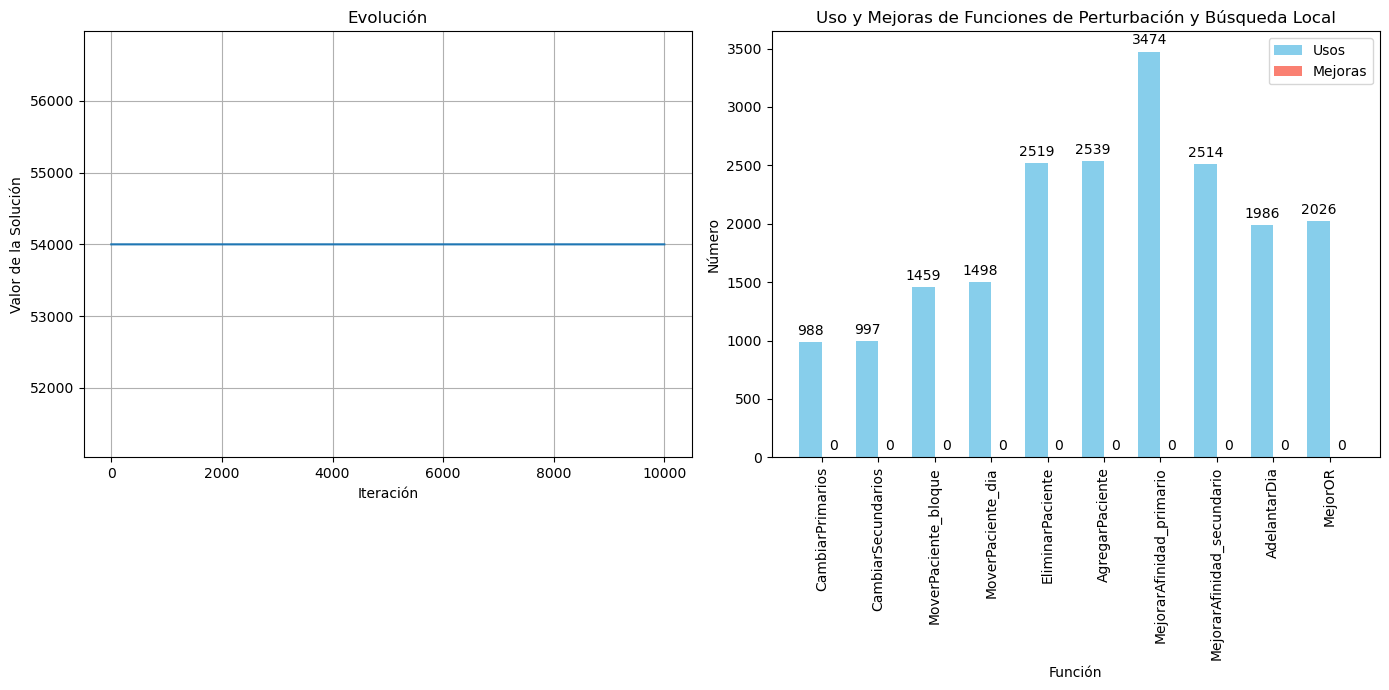

In [54]:
def PlotStats(lista_solucion: list, lista_iteracion: dict, counts: dict, improves: dict):
    labels = list(counts.keys())
    usage_values = list(counts.values())
    improvement_values = list(improves.values())
    
    x = np.arange(len(labels));
    width = 0.4;

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    ax1.plot(lista_iteracion, lista_solucion)
    ax1.set_xlabel('Iteración')
    ax1.set_ylabel('Valor de la Solución')
    ax1.set_title('Evolución')
    ax1.grid(True)
    
    bars1 = ax2.bar(x - width/2, usage_values, width, label='Usos', color='skyblue')
    bars2 = ax2.bar(x + width/2, improvement_values, width, label='Mejoras', color='salmon')

    ax2.set_xlabel('Función')
    ax2.set_ylabel('Número')
    ax2.set_title('Uso y Mejoras de Funciones de Perturbación y Búsqueda Local')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=90)
    ax2.legend()
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax2.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    add_labels(bars1)
    add_labels(bars2)
    plt.tight_layout()
    plt.show()
    
PlotStats(stats[0], stats[1], stats[2], stats[3])

## Mostrar schedule

In [16]:
print(EvalAllORs(best_solution, hablar=True))
#print(best_solution)
graficar_solucion(best_solution)

Score para OR 0: 39000.

Score para OR 1: 60000.

Score para OR 2: 104000.

Score para OR 3: 76000.

Fichas: [[-20, -45, -36, -14, -61], [40, 80, 120, 160, 102], [33, 50, 90, 130, 155], [40, 24, 50, 90, 78], [20, -3, 13, 14, 54], [-8, 32, 40, 27, 67], [1, 2, -22, -28, -1], [10, 50, 17, 1, 41], [2, 0, 40, 44, 69], [40, 35, 19, 11, 0]]
236292
OR 0:
         Día 0       Día 1       Día 2       Día 3       Día 4
T0   (0, 6, 1)         NaN         NaN   (6, 6, 1)   (9, 0, 1)
T1   (0, 6, 1)  (12, 4, 0)  (66, 6, 3)   (7, 0, 1)  (60, 6, 1)
T2   (1, 6, 1)  (13, 4, 0)   (5, 0, 1)   (8, 0, 1)  (60, 6, 1)
T3   (2, 6, 1)  (14, 4, 0)   (5, 0, 1)   (8, 0, 1)  (60, 6, 1)
T4  (10, 4, 0)  (15, 4, 0)  (40, 7, 8)   (8, 0, 1)  (44, 1, 7)
T5  (10, 4, 0)  (16, 4, 0)  (41, 7, 8)  (19, 4, 1)  (45, 1, 7)
T6  (10, 4, 0)  (17, 4, 0)  (42, 7, 8)  (70, 4, 2)  (46, 1, 7)
T7  (11, 4, 0)  (18, 4, 0)  (43, 7, 8)  (71, 4, 9)  (47, 1, 6)


OR 1:
         Día 0       Día 1        Día 2        Día 3        Día 4
T0  (61, 0

## Graficar solución (LPM)

In [ ]:
pacientes = [94, 44, 45, 47, 40, 42, 0, 46, 1, 41, 134, 133, 132, 128, 122, 130, 145, 120, 123, 121, 81, 82, 80, 87, 83, 85, 124, 126, 127, 125, 23, 139]
primarios = {94: 0, 95: 0, 44: 6, 45: 0, 47: 6, 40: 6, 42: 6, 43: 6, 0: 0, 46: 6, 1: 0, 2: 0, 3: 0, 41: 6, 134: 2, 133: 8, 132: 2, 128: 8, 129: 8, 122: 8, 130: 8, 131: 8, 145: 8, 146: 8, 147: 8, 120: 8, 123: 2, 121: 8, 81: 5, 82: 5, 80: 5, 87: 5, 83: 5, 85: 5, 124: 7, 126: 7, 127: 1, 125: 7, 23: 7, 139: 7}
secundarios = {94: 5, 95: 5, 44: 8, 45: 5, 47: 0, 40: 4, 42: 0, 43: 0, 0: 1, 46: 0, 1: 5, 2: 5, 3: 5, 41: 3, 134: 4, 133: 4, 132: 5, 128: 5, 129: 5, 122: 2, 130: 2, 131: 2, 145: 2, 146: 2, 147: 2, 120: 0, 123: 4, 121: 2, 81: 8, 82: 4, 80: 9, 87: 3, 83: 8, 85: 1, 124: 9, 126: 3, 127: 6, 125: 6, 23: 9, 139: 9}

print(EvalAllORs((pacientes, primarios, secundarios), hablar=True))
graficar_solucion((pacientes, primarios, secundarios))

# GP

In [ ]:
asignP = [-1] * len(patient);
asignS = [[] for _ in range(len(surgeon))];
asignA = [[] for _ in range(len(second))];

pset = gp.PrimitiveSet("MAIN", 0);

def mostrar(text: str):
    if hablar:
        print(text);
def CirujanosCompatibles(sol: tuple, p:int, primario: bool=True) -> list:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    dur = OT[p];
    t = pacientes[p];
    compatible_surgeons = [];
    if primario:
        compatible_surgeons_set = {s for s in surgeon if SP[p][s] == 1};
        for s in compatible_surgeons_set:
            compatible = True;
            for b in range(dur):
                current_block = t + b;
                current_day_time = decompress(current_block)[1:];
                if any(decompress(block)[1:] == current_day_time and primarios.get(block) == s for block in primarios):
                    compatible = False;
                    break
            if compatible:
                compatible_surgeons.append(s);
    else:
        for a in second:
            compatible = True;
            for b in range(dur):
                current_block = t + b;
                current_day_time = decompress(current_block)[1:];
                if any(decompress(block)[1:] == current_day_time and secundarios.get(block) == a for block in primarios):
                    compatible = False;
                    break
            if compatible:
                compatible_surgeons.append(a);            
    return compatible_surgeons
def EncontrarEspacio(sol: tuple, p: int, o: int, d:int) -> list:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    dur = OT[p];
    espacios_disponibles = [];
    for t in range(nSlot - dur + 1):
        espacio_continuo = True;
        for b in range(dur):
            current_block = compress(o, d, t + b)
            if primarios.get(current_block) is not None or AOR[p][o][t + b][d] != 1:
                espacio_continuo = False;
                break
        if espacio_continuo:
            espacios_disponibles.append(compress(o, d, t));
    return espacios_disponibles
def MoverPaciente(sol: tuple, p: int, desde:int, hasta:int) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    dur = OT[p];
    prim_disp = [s for s in surgeon if SP[p][s] == 1];
    sec_disp = [a for a in second];
    if not prim_disp or not sec_disp:
        print("No hay cirujanos disponibles para el paciente.");
        return (pacientes, primarios, secundarios)
    espacio_continuo = True;
    for b in range(dur):
        current_block = hasta + b
        if current_block in primarios or current_block in secundarios:
            espacio_continuo = False;
            break;
    if not espacio_continuo:
        print("No hay espacio disponible para mover el paciente.")
        return (pacientes, primarios, secundarios)

    pacientes[p] = hasta;
    for b in range(dur):
        del primarios[desde + b];
        del secundarios[desde + b];
        current_block = hasta + b;
        primarios[current_block] = random.choice(prim_disp);
        secundarios[current_block] = random.choice(sec_disp);
    return (pacientes, primarios, secundarios)

#TERMINALES
#ILS: Pertubaciones
def CambiarPrimarios(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    p1, p2 = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 2);
    t1, t2 = pacientes[p1], pacientes[p2];
    cir1, cir2 = primarios[t1], primarios[t2];
    dur1, dur2 = int(OT[p1]), int(OT[p2]);
    mostrar(f"Moviendo cirujano primario {cir1} desde {t1} hasta {t2}...");
    for t in range(dur1):
        primarios[t1 + t] = cir2;
    mostrar(f"Moviendo cirujano primario {cir2} desde {t2} hasta {t1}...");
    for t in range(dur2):
        primarios[t2 + t] = cir1;
    mostrar("Primarios intercambiados.");
    return True

def CambiarSecundarios(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    p1, p2 = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 2);
    t1, t2 = pacientes[p1], pacientes[p2];
    cir1, cir2 = secundarios[t1], secundarios[t2];
    dur1, dur2 = int(OT[p1]), int(OT[p2]);
    mostrar(f"Moviendo cirujano secundario {cir1} desde {t1} hasta {t2}...");
    for t in range(dur1):
        secundarios[t1 + t] = cir2;
    mostrar(f"Moviendo cirujano secundario {cir2} desde {t2} hasta {t1}...");
    for t in range(dur2):
        secundarios[t2 + t] = cir1;
    mostrar("Secundarios intercambiados.");
    return True

def MoverPaciente_bloque(sol: tuple) -> tuple:
    pac_aux, prim_aux, sec_aux = sol[0].copy(), sol[1].copy(), sol[2].copy();
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    prim = primarios[pacientes[p]];
    sec = secundarios[pacientes[p]];
    o, d, t = decompress(pacientes[p]);
    dur = OT[p];
    mov = random.choice([-1, 1]);
    if t + mov >= 1 and t + mov < nSlot - dur:
        if mov == -1:
            if pacientes[p] - 1 in primarios:
                mostrar(f"Paciente {p} (duración {dur}) no pudo moverse (bloque {t}).");
                return False
            else:
                del primarios[pacientes[p] + dur - 1];
                del secundarios[pacientes[p] + dur - 1];
                primarios[pacientes[p] - 1] = prim;
                secundarios[pacientes[p] - 1] = sec;
                pacientes[p] = compress(o, d, t+mov);
                mostrar(f"Paciente {p} (duración {dur}) movido de bloque {t} a bloque {t+mov}.");
                return True
        else:
            if pacientes[p] + dur in primarios:
                mostrar(f"Paciente {p} (duración {dur}) no pudo moverse (bloque {t}).");
                return False
            else:
                del primarios[pacientes[p]];
                del secundarios[pacientes[p]];
                primarios[pacientes[p] + dur] = prim;
                secundarios[pacientes[p] + dur] = sec;
                pacientes[p] = compress(o, d, t+mov);
                mostrar(f"Paciente {p} (duración {dur}) movido de bloque {t} a bloque {t+mov}.");
                return True
    mostrar(f"Paciente {p} (duración {dur}) no pudo moverse desde bloque {t} hasta bloque {t+mov}.");
    return False

def MoverPaciente_dia(sol: tuple) -> tuple:
    pac_aux, prim_aux, sec_aux = sol[0].copy(), sol[1].copy(), sol[2].copy();
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    prim = primarios[pacientes[p]];
    sec = secundarios[pacientes[p]];
    o, d, t = decompress(pacientes[p]);
    dur = int(OT[p]);
    mov = random.choice([-1, 1]);
    if d + mov >= 1 and d + mov < nDays:
        for b in range(dur):
            bloque = compress(o, d+mov, t+b)
            if bloque in primarios:
                mostrar(f"Paciente {p} no pudo moverse desde día {d} hasta día {d+mov}.");
                return False
            else:
                del primarios[compress(o, d, t+b)];
                primarios[bloque] = prim;
                del secundarios[compress(o, d, t+b)];
                secundarios[bloque] = sec;
        pacientes[p] = compress(o, d+mov, t);
        mostrar(f"Paciente {p} movido desde día {d} hasta día {d+mov}.");
        return True
    mostrar(f"Paciente {p} no pudo moverse desde día {d} hasta día {d+mov}.");
    return False

def EliminarPaciente(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    try:
        p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    except:
        mostrar("No hay pacientes asignados.");
        return False
    dur = int(OT[p]);
    for b in range(dur):
        del primarios[pacientes[p] + b];
        del secundarios[pacientes[p] + b];
    pacientes[p] = -1;
    mostrar(f"Paciente {p} eliminado.");
    return True

def AgregarPaciente(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    try:
        p = random.sample([i for i, paciente in enumerate(pacientes) if paciente == -1], 1)[0];
    except:
        mostrar("No hay pacientes para agregar.");
        return False
    dur = int(OT[p]);
    c = compress(o, d, t);
    disponible = [c for o in room for t in slot for d in day if AOR[p][o][t][d] == 1 and c not in primarios];
    if len(disponible) < dur:
        mostrar("No hay espacio para asignar.");
        return False
    disponible.sort();
    pos = random.choice(range(len(disponible)));
    val = disponible[pos];
    prim_disp = [s for s in surgeon if all(decompress(c)[1:] != decompress(val + b)[1:] for c in primarios if primarios[c] == s)];
    sec_disp = [a for a in second];
    if not prim_disp or not sec_disp:
        mostrar("No hay cirujanos disponibles.")
        return False
    pacientes[p] = val;
    for b in range(dur):
        primarios[val + b] = random.choice(prim_disp);
        secundarios[val + b] = random.choice(sec_disp);
    return True

#ILS: Búsquedas Locales    
def MejorarAfinidad_primario(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    try:
        p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    except:
        mostrar("No hay cirugías programadas.");
        return False
    cir = primarios[pacientes[p]];
    sec = secundarios[pacientes[p]];
    costo = dictCosts[(cir, sec, pacientes[p])];
    comp = CirujanosCompatibles((pacientes, primarios, secundarios), p, True);
    if len(comp) == 0:
        mostrar("No hay primarios disponibles para cambio.");
        return False
    best = cir;
    for s in comp:
        if s != sec:
            if dictCosts[(s, sec, pacientes[p])] >= costo:
                costo = dictCosts[(s, sec, pacientes[p])];
                best = s;
    for b in range(OT[p]):
        primarios[pacientes[p] + b] = best;
    mostrar(f"Por afinidad, se ha cambiado al cirujano primario {cir} por el cirujano primario {best}.");
    return True

def MejorarAfinidad_secundario(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    try:
        p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    except:
        mostrar("No hay cirugías programadas.");
        return False
    cir = primarios[pacientes[p]];
    sec = secundarios[pacientes[p]];
    costo = dictCosts[(cir, sec, pacientes[p])];
    comp = CirujanosCompatibles((pacientes, primarios, secundarios), p, False);
    if len(comp) == 0:
        mostrar("No hay secundarios disponibles para cambio.");
        return False
    best = sec;
    for a in comp:
        if a != cir:
            if dictCosts[(cir, a, pacientes[p])] >= costo:
                costo = dictCosts[(cir, a, pacientes[p])];
                best = a;
    for b in range(OT[p]):
        secundarios[pacientes[p] + b] = best;
    mostrar(f"Por afinidad, se ha cambiado al cirujano secundario {sec} por el cirujano secundario {best}.");
    return True

def AdelantarDia(sol: tuple) -> tuple:
    pacientes, primarios, secundarios = sol[0].copy(), sol[1].copy(), sol[2].copy();
    p_ori, s_ori, a_ori = sol[0].copy(), sol[1].copy(), sol[2].copy();
    try:
        p = random.sample([i for i, paciente in enumerate(pacientes) if paciente != -1], 1)[0];
    except:
        mostrar("No hay cirugías programadas.");
        return False
    o, d, t = decompress(pacientes[p]);
    for dia in range(d):
        disp = EncontrarEspacio((pacientes, primarios, secundarios), p, o, dia);
        if len(disp) > 0: 
            dur = OT[p];
            for b in range(dur):
                current_block = pacientes[p] + b
                if current_block in primarios:
                    del primarios[current_block];
                if current_block in secundarios:
                    del secundarios[current_block];
            pacientes[p] = disp[0];
            prim_disp = CirujanosCompatibles((pacientes, primarios, secundarios), p);
            sec_disp = [a for a in second];
            if not prim_disp or not sec_disp:
                mostrar("No hay cirujanos disponibles para el paciente a esa hora.")
                return False
            prim = random.choice(prim_disp);
            sec = random.choice(sec_disp);
            for b in range(dur):
                current_block = disp[0] + b
                primarios[current_block] = prim;
                secundarios[current_block] = sec;
            mostrar(f"Paciente {p} movido desce  el día {d} hasta el día {dia}.");
            return True
    mostrar("No se encontró espacio disponible en días anteriores.")
    return False

pset.addTerminal(CambiarPrimarios, name="CambiarPrimario");
pset.addTerminal(CambiarSecundarios, name="CambiarSecundario");
pset.addTerminal(MoverPaciente_bloque, name="MoverPacienteB");
pset.addTerminal(MoverPaciente_dia, name="MoverPacienteD");
pset.addTerminal(AgregarPaciente, name="AgregarPaciente");
pset.addTerminal(EliminarPaciente, name="EliminarPaciente");
pset.addTerminal(MejorarAfinidad_primario, name="MejorarAfinidadP");
pset.addTerminal(MejorarAfinidad_secundario, name="MejorarAfinidadS");
pset.addTerminal(AdelantarDia, name="AdelantarDia");

#PRIMITIVAS

def if_then_else(condition, out1, out2):
    try:
        out1() if condition() else out2();
        return True
    except TypeError:
        return True

def And(out1, out2):
    try:
        oli = out1() and out2()
        return oli
    except TypeError:
        return True

def Or(out1, out2):
    try:
        oli = out1() or out2()
        return oli
    except TypeError:
        return True
    
def While(condition, action):
    i = 0;
    try:
        oli = condition();
        while oli and i < 20:
            action(); 
            if not condition():
                break;
            i += 1;
        return True
    except TypeError:
        return True
    
#def sequential2
#def sequential3

pset.addPrimitive(if_then_else, 3);
pset.addPrimitive(And, 2);
pset.addPrimitive(Or, 2);
pset.addPrimitive(While, 2);

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalAllORs(sol, hablar=False):
    pacientes, primarios, secundarios = sol;
    puntaje = 0;
    for or_id in room:
        points = evalSchedule(pacientes, primarios, secundarios, or_id, hablar);
        puntaje += points;
        if hablar:
            print(f"Score para OR {or_id}: {points}.\n");
    return puntaje

def evalSchedule(pacientes, primarios, secundarios, or_id, hablar=False):
    bloques_por_paciente = {};
    penalizaciones = 0;
    registros = set();
    fichas = [[int(instancia[INS][4]) * (d+1) for d in range(nDays)] for s in surgeon];
    score = 0;
    for p in range(len(pacientes)):
        if pacientes[p] != -1:
            o_p, d_p, t_p = decompress(pacientes[p])
            if o_p == or_id:
                duracion = OT[p];
                prioridad_paciente = I[(p, d_p)];
                if p not in bloques_por_paciente:
                    bloques_por_paciente[p] = [];
                    score += 1000 * prioridad_paciente;
                for b in range(int(duracion)):
                    t_actual = t_p + b;
                    bloque_horario = compress(o_p, d_p, t_actual);
                    bloques_por_paciente[p].append(bloque_horario);

                    #s = [prim for prim, asign in enumerate(primarios) if bloque_horario in asign][0];
                    #a = [sec for sec, asign in enumerate(secundarios) if bloque_horario in asign][0];
                    
                    s = primarios[bloque_horario];
                    a = secundarios[bloque_horario];
                    
                    for d in range(d_p, nDays):
                        fichas[s][d] -= dictCosts[(s, a, bloque_horario)];

                    if SP[p][s] != 1:
                        penalizaciones += 10;  #Penalización si la especialidad no coincide
                        if hablar:
                            print(f"Penalización: Especialidad del cirujano {s} no coincide para paciente {p} en OR {or_id}.");
                    if s == a:
                        penalizaciones += 10;  #Penalización por ser mismo cirujano principal y secundario
                        if hablar:
                            print(f"Penalización: Cirujano principal y secundario son la misma persona para paciente {p} en OR {or_id}.");
                    # if (s, bloque_horario) in registros:
                    #     penalizaciones += 50;  #Penalización por asignar a un mismo bloque horario
                    #     if hablar:
                    #         print(f"Penalización: Cirujano {s} reasignado en el mismo bloque {bloque_horario} en OR {or_id}.");
                    #registros.add((s, bloque_horario));

    for paciente_id, bloques in bloques_por_paciente.items():
        bloques.sort();
        duracion = OT[paciente_id];
        if len(bloques) != duracion:
            penalizaciones += 50 * len(bloques)  #Penalizar por cada bloque asignado mal
            if hablar:
                print(f"Penalización: Duración incorrecta para paciente {paciente_id} en OR {or_id}. Esperado: {duracion}, Obtenido: {len(bloques)}.")
        if not all(bloques[i] + 1 == bloques[i + 1] for i in range(len(bloques) - 1)):
            penalizaciones += 100 * len(bloques)  #Penalización por cada bloque no consecutivo
            if hablar:
                print(f"Penalización: Bloques no consecutivos para paciente {paciente_id} en OR {or_id}.");
    score -= 10 * penalizaciones  #Restar las penalizaciones del score total
    for d in range(nDays):
        for s in surgeon:
            score -= fichas[s][d] * nDays//(d+1);
    if hablar:
        print(f"Score final para OR {or_id}: {score}");
    return score


toolbox.register("evaluate", evalPlanificacion);
toolbox.register("select", tools.selTournament, tournsize=3);
toolbox.register("mate", gp.cxOnePoint);
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset);
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17));
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17));

# Función principal para ejecutar el algoritmo genético
def main():
    random.seed(258)
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.1, 50, stats=mstats, halloffame=hof, verbose=True)
    best_ind = tools.selBest(pop, 1)[0]
    print("Mejor individuo es:", best_ind)
    print("Con un fitness de:", best_ind.fitness.values)

    return pop, log, hof

if __name__ == "__main__":
    main()

In [90]:
x = 2;
print("Hola") if x == 1 else None;